<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-Bethe-lattice-subgraph" data-toc-modified-id="Create-a-Bethe-lattice-subgraph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a Bethe lattice subgraph</a></span></li><li><span><a href="#Get-contraction-cost-estimations" data-toc-modified-id="Get-contraction-cost-estimations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get contraction cost estimations</a></span></li><li><span><a href="#Bethe-lattice-subgraphs-complexity-estimation" data-toc-modified-id="Bethe-lattice-subgraphs-complexity-estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bethe lattice subgraphs complexity estimation</a></span></li></ul></div>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import qtensor as qt
from cartesian_explorer import Explorer
import cartesian_explorer.caches as caches


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#ex = Explorer(cache=caches.JobLibCache(cachedir='../../data/cache/tree_subgraph2'))
ex = Explorer()

## Create a Bethe lattice subgraph

In [4]:
@ex.provider
def bethe_graph(p, degree):
    def add_two_nodes_to_leafs(graph):
        """ Works in-place """
        leaves = [n for n in graph.nodes() if graph.degree(n) <= degree-2]
        n = graph.number_of_nodes()
        for leaf in leaves:
            next_edges = [(leaf, n+x) for x in range(1, degree)]
            graph.add_edges_from(next_edges)
            n += 2
    graph = nx.Graph()
    graph.add_edges_from([(0,1)])
    for i in range(p):
        add_two_nodes_to_leafs(graph)
    print('bethe lattice nodes', graph.number_of_nodes())
    return graph



bethe lattice nodes 30


Text(0.5, 1.0, 'Bethe lattice subgraph for p=4')

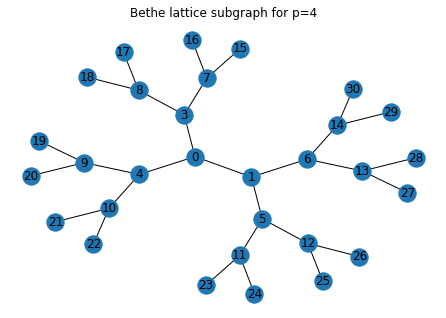

In [5]:
G = bethe_graph(p=3, degree=3)
nx.draw_kamada_kawai(G, with_labels=True)
plt.title('Bethe lattice subgraph for p=4')

In [7]:
@ex.provider
def bethe_lightcone_circuit(bethe_graph, beta, gamma, composer_type='cone'):
    if composer_type=='cone':
        Composer = qt.QtreeQAOAComposer
    elif composer_type=='ZZ':
        Composer = qt.ZZQtreeQAOAComposer
    elif composer_type=='default':
        Composer = qt.DefaultQAOAComposer
    
    print('beta, gamma', beta, gamma, 'type', composer_type)
    comp = Composer(bethe_graph, gamma=gamma, beta=beta)
    comp.energy_expectation_lightcone((0, 1))
    print('len', len(comp.circuit))
    return tuple(comp.circuit)
    

In [11]:
circ = bethe_lightcone_circuit(G, (0.1,)*4, (0.2,)*4)
circ = bethe_lightcone_circuit(G, (0.1,)*4, (0.2,)*4, composer_type='default')
print('Number of gates in circ: ', len(circ))

Number of gates in circ:  318


## Get contraction cost estimations

In [12]:
@ex.provider
def circuit_sim_costs(bethe_lightcone_circuit):
    circuit = bethe_lightcone_circuit
    tn = qt.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(circuit)
    opt = qt.optimisation.Optimizer.DefaultOptimizer()
    peo, _ = opt.optimize(tn)
    costs, mems = tn.simulation_cost(peo)
    print('tn', tn.get_line_graph().number_of_nodes())
    return tuple(costs), tuple(mems)

@ex.provider
def max_memory(circuit_sim_costs):
    costs, mems = circuit_sim_costs
    return max(mems)

@ex.provider
def sum_flops(circuit_sim_costs):
    costs, mems = circuit_sim_costs
    return sum(costs)

beta, gamma (0.3, 0.3, 0.3) (0.2, 0.2, 0.2) type cone
len 444
tn 378


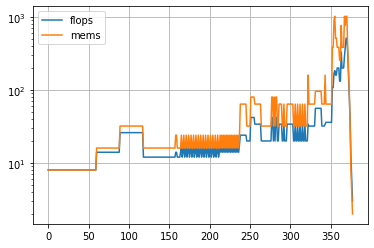

In [13]:
p = 3
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.3, )*p,
                    degree=3
                   )

plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()

beta, gamma (0.3, 0.3, 0.3) (0.2, 0.2, 0.2) type default
len 200
tn 134


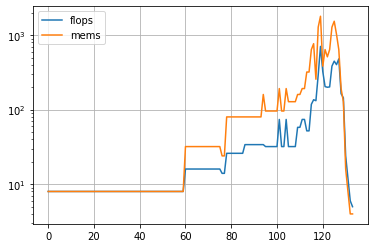

In [14]:
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.3, )*p,
                              degree=3, composer_type='default'
                             )
plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()

In [15]:
@ex.provider
def expectation_value(bethe_lightcone_circuit):
    circuit = bethe_lightcone_circuit
    sim = qt.QtreeSimulator()
    E = sim.simulate(circuit)
    return E[0]

In [16]:
gamma = np.array([-1.358922, 0.40041, -1.101348])
beta = np.array([-0.6072757, -0.45687, 0.2329651])
gamma *= -1/np.pi
beta *= 1/np.pi
E = ex.get_variable('expectation_value', p=3, degree=3,
                    gamma=tuple(gamma), beta=tuple(beta))
print('Expectation', E)

beta, gamma (-0.1933018589491818, -0.14542623770078844, 0.07415509446579542) (0.4325583071526492, -0.12745446152685164, 0.3505699565287455) type cone
len 444
Expectation (-0.584775547118884-6.453171330633722e-16j)


In [17]:
@ex.add_function(provides=('beta', 'gamma'), requires='p')
def get_dummy_beta_gamma(p):
    beta = [.1]*p
    gamma = [.2]*p
    return tuple(beta), tuple(gamma)

## Bethe lattice subgraphs complexity estimation

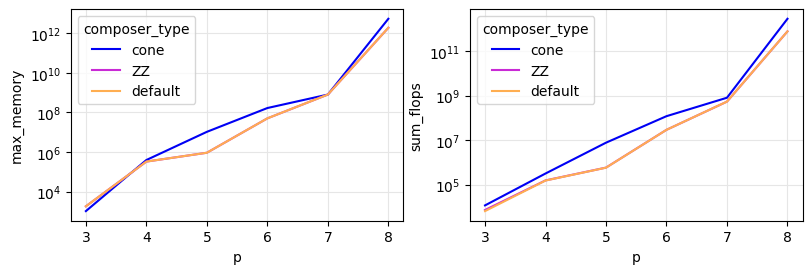

In [25]:
ps = [3, 4, 5, 6, 7, 8]
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    degree = [3],
                    composer_type = ['cone', 'ZZ', 'default'],
                    p=ps,
                   )
for ax in f.axes:
    plt.sca(ax)
    plt.yscale('log')

bethe lattice nodes 510
beta, gamma (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2) type new
my type is QtreeQAOAComposer
len 2660
tn 2762
bethe lattice nodes 1022
beta, gamma (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2) type new
my type is QtreeQAOAComposer
len 3918
tn 4474
bethe lattice nodes 2046
beta, gamma (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2) type new
my type is QtreeQAOAComposer
len 6200
tn 7722
bethe lattice nodes 4094
beta, gamma (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2) type new
my type is QtreeQAOAComposer
len 10530
tn 14042



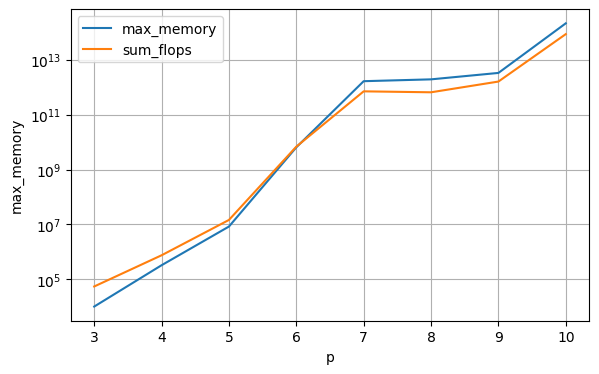

In [16]:
ps = [3, 4, 5, 6, 7, 8, 9, 10]
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    degree = [3],
                    composer_type = ['new'],
                    p=ps,
                   )
for ax in f.axes:
    plt.sca(ax)
    plt.grid()
    plt.yscale('log')

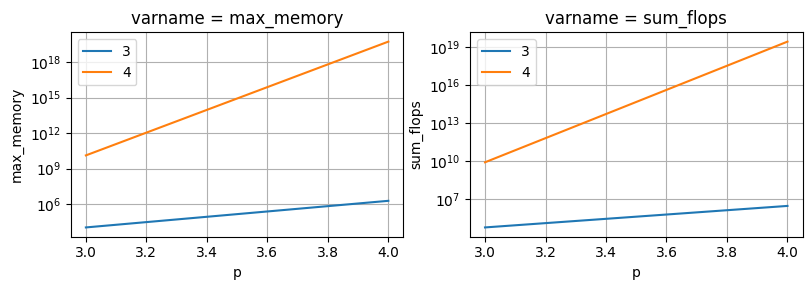

In [120]:
ps = [3, 4, ]
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    degree = [3, 4],
                    p=ps,
                   )
for ax in f.axes:
    plt.sca(ax)
    plt.grid()
    plt.yscale('log')

beta, gamma (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2) type old
my type is OldQtreeQAOAComposer
len 67406


KeyboardInterrupt: 

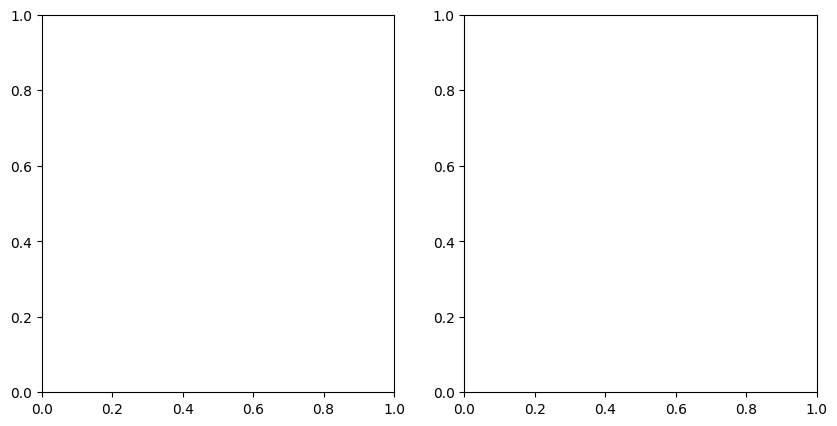

In [17]:
p = 8
f, axs = plt.subplots(1,2,figsize=(10, 5), dpi=100)
plt.sca(axs[0])
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='old'
                   )


plt.sca(axs[0])
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='new'
                   )

for ax in axs:
    plt.sca(ax)
    plt.plot(flops, label='flops')
    plt.plot(mems, label='mems')
    plt.legend()
    plt.yscale('log')
    plt.grid()

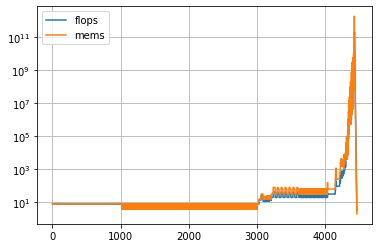

In [132]:
p = 8
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='new'
                   )

plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()

sum flops 3.688834e+11


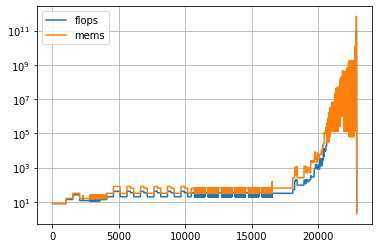

In [131]:
p = 7
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='old'
                   )

plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()
print(f'sum flops {sum(flops):e}')

sum flops 7.043013e+11


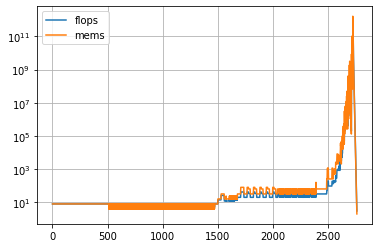

In [130]:
p = 7
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='new'
                   )

plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()
print(f'sum flops {sum(flops):e}')

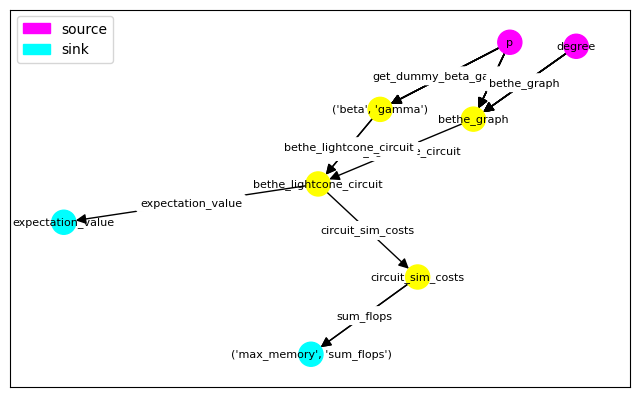

In [125]:
_ = ex.draw_dependency_graph()